# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент федерального оператора сотовой связи хочет понять, какой тариф приносит больше денег. Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


### Описание тарифов:

**Тариф «Смарт»:**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - Минута разговора — 3 рубля. Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута;
    - Сообщение — 3 рубля;
    - 1 Гб интернет-трафика — 200 рублей.

**Тариф «Ультра»:**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - Минута разговора — 1 рубль;
    - Сообщение — 1 рубль;
    - 1 Гб интернет-трафика: 150 рублей.
    
    
### Описание данных:

**Таблица users (информация о пользователях):**
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана


**Таблица calls (информация о звонках):**
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок


**Таблица messages (информация о сообщениях):**
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение


**Таблица internet (информация об интернет-сессиях):**
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя


**Таблица tariffs (информация о тарифах):**
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то - со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from scipy import stats as st
from functools import reduce

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# сделаем настройку для удобства и наглядности

# снимем ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставим ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавим стиль графиков
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook') 
sns.set_style('ticks') 
sns.set_style('whitegrid')

In [3]:
# считаем данные из csv файлов и сохраним их в переменные

# информация о звонках
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')

# информация об интернет-сессиях
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')

# информация о сообщениях
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')

# информация о тарифах
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')

# информация о пользователях
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

In [4]:
# создадим функцию для вывода общей информации о датафреймах
def data_info(data):
    print(data.info())
    display(data.head())

In [5]:
# информация о звонках
data_info(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
# информация об интернет-сессиях
data_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
# информация о пользователях
data_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
# информация о сообщениях
data_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
# информация о тарифах
data_info(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


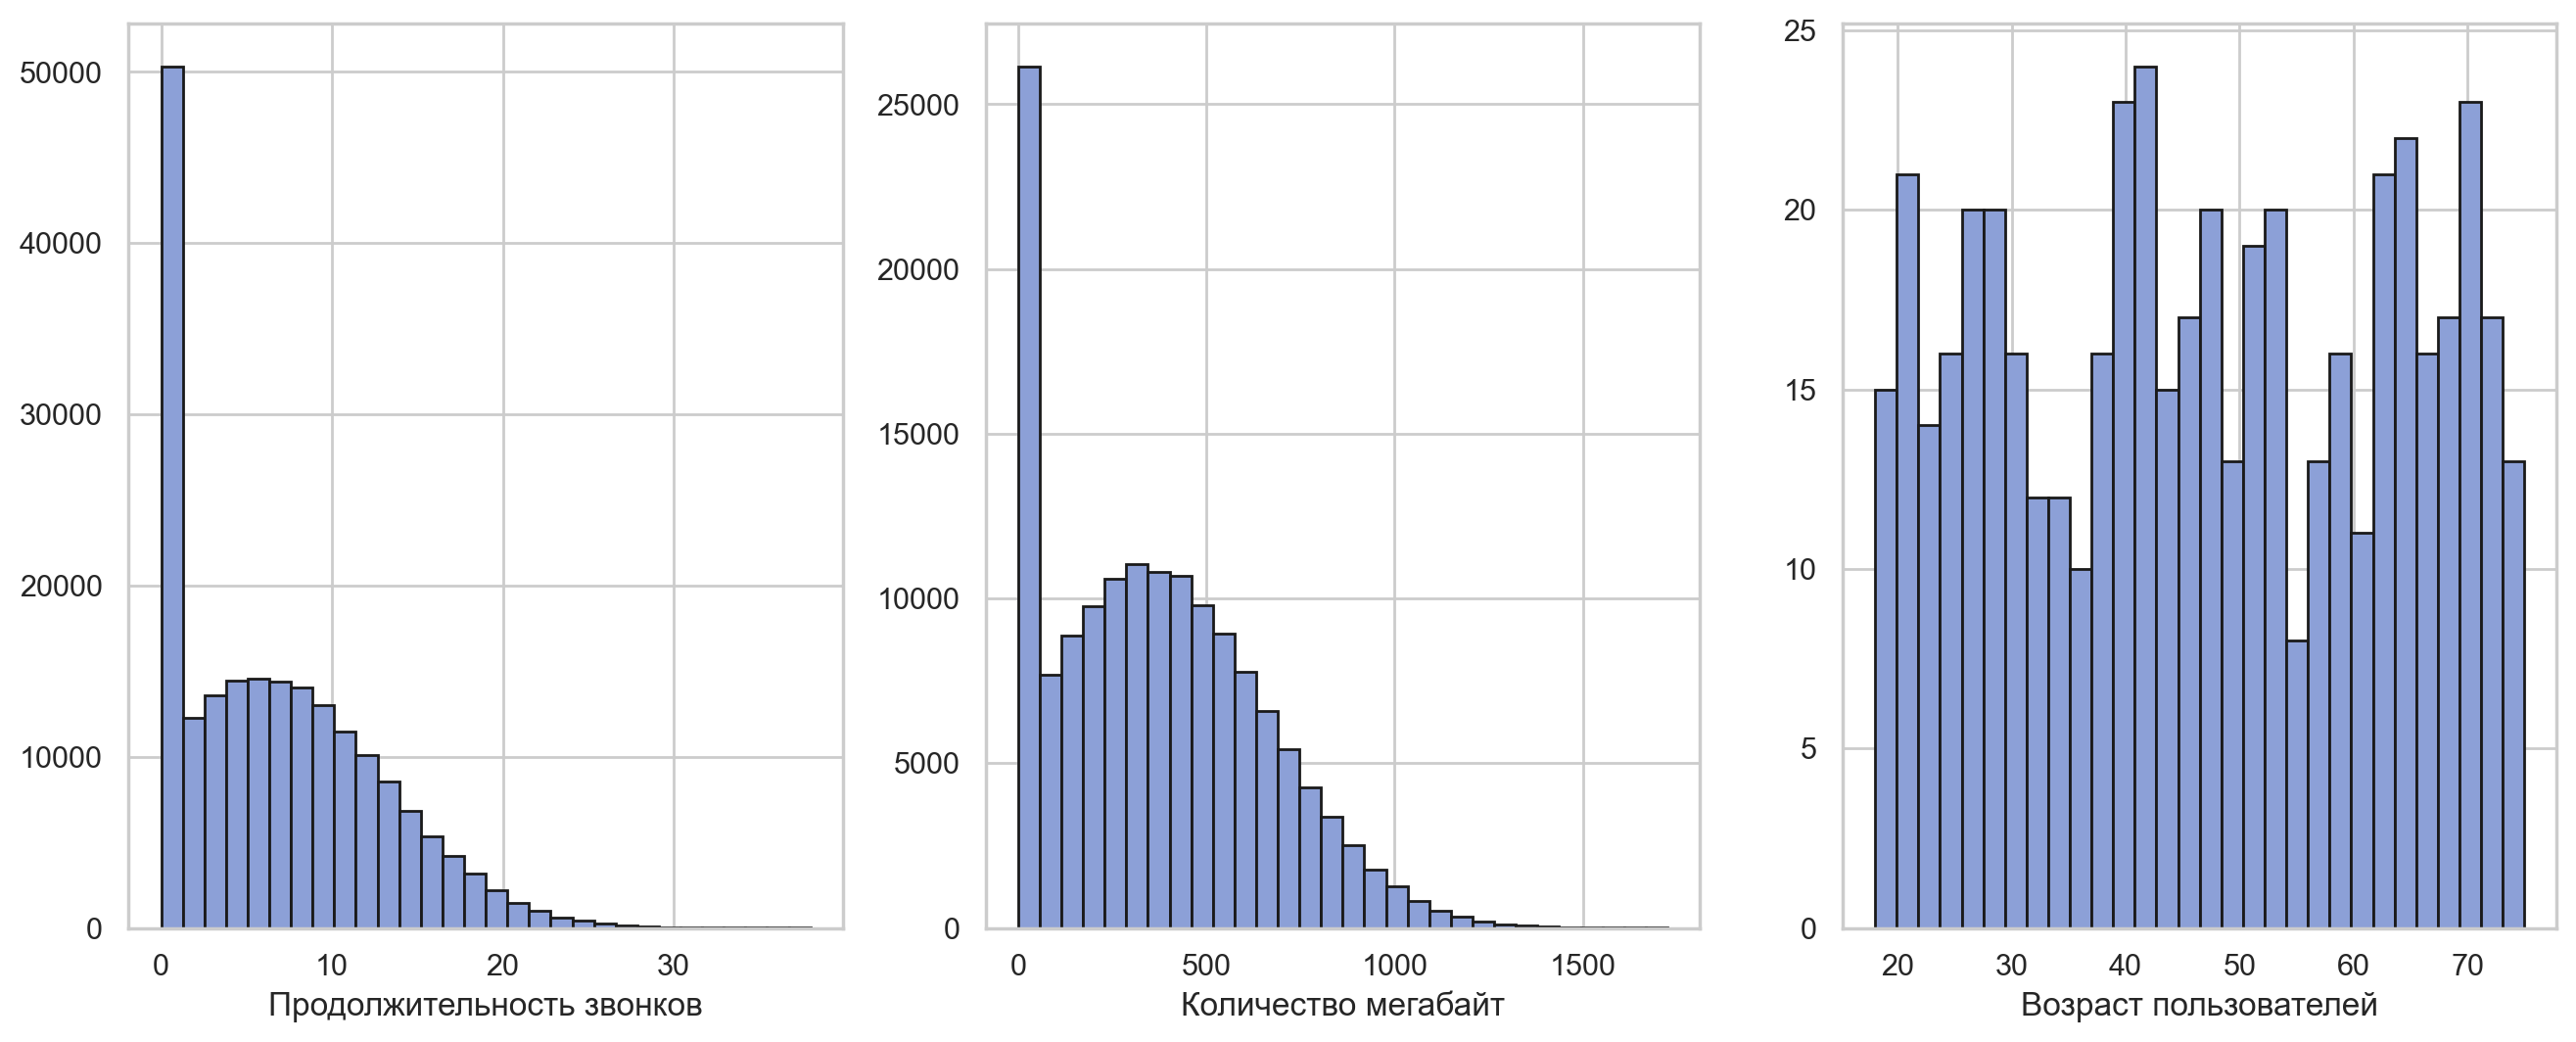

In [10]:
# построим распределения
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# звонки
calls.duration.hist(ax=axes[0], bins=30, color = '#8CA0D7', ec='k')
axes[0].set(xlabel='Продолжительность звонков')
            
internet.mb_used.hist(ax=axes[1], bins=30, color = '#8CA0D7', ec='k')
axes[1].set(xlabel='Количество мегабайт')

users.age.hist(ax=axes[2], bins=30, color = '#8CA0D7', ec='k')
axes[2].set(xlabel='Возраст пользователей')

plt.show()

### Вывод по шагу "Изучение данных из файла": 

1. Файл содержит данные по 500 клиентам. Потребуется заменить тип данных у столбцов с датой и временем, а также округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам.


2. Кроме этого, после объединения данных (сводная таблица по звонкам, по сообщениям и интернет-трафику) возникнут пропущенные значения (клиент мог в каком-то месяце не писать сообщений, но звонить и использовать интернет), которые также нужно будет заменить на нули.

## Предобработка данных 

На этом этапе:

1. Заменим типы данных
2. Исправим ошибки в данных
3. Соберем сводную информацию для каждого пользователя

### Замена типов данных

Заменим тип данных, обозначающих дату, со строчного на временной.

In [11]:
# обработка столбца reg_date
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

# обработка столбца churn_date
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

# обработка столбца call_date
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# обработка столбца message_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# обработка столбца session_date
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

**Вывод:**

Все даты были заменены со строчного формата на временной.

### Исправление ошибок в данных

- В данных видим звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять. Округлим все значения в большую сторону.

- В данных также видим нулевые интернет-сессии. Округлим все значения в большую сторону.

**1. Звонки**

In [12]:
# определим количество звонков с нулевой длительностью
print('Количество звонков с длительностью, равной нулю:'\
      , calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0])

Количество звонков с длительностью, равной нулю: 39613


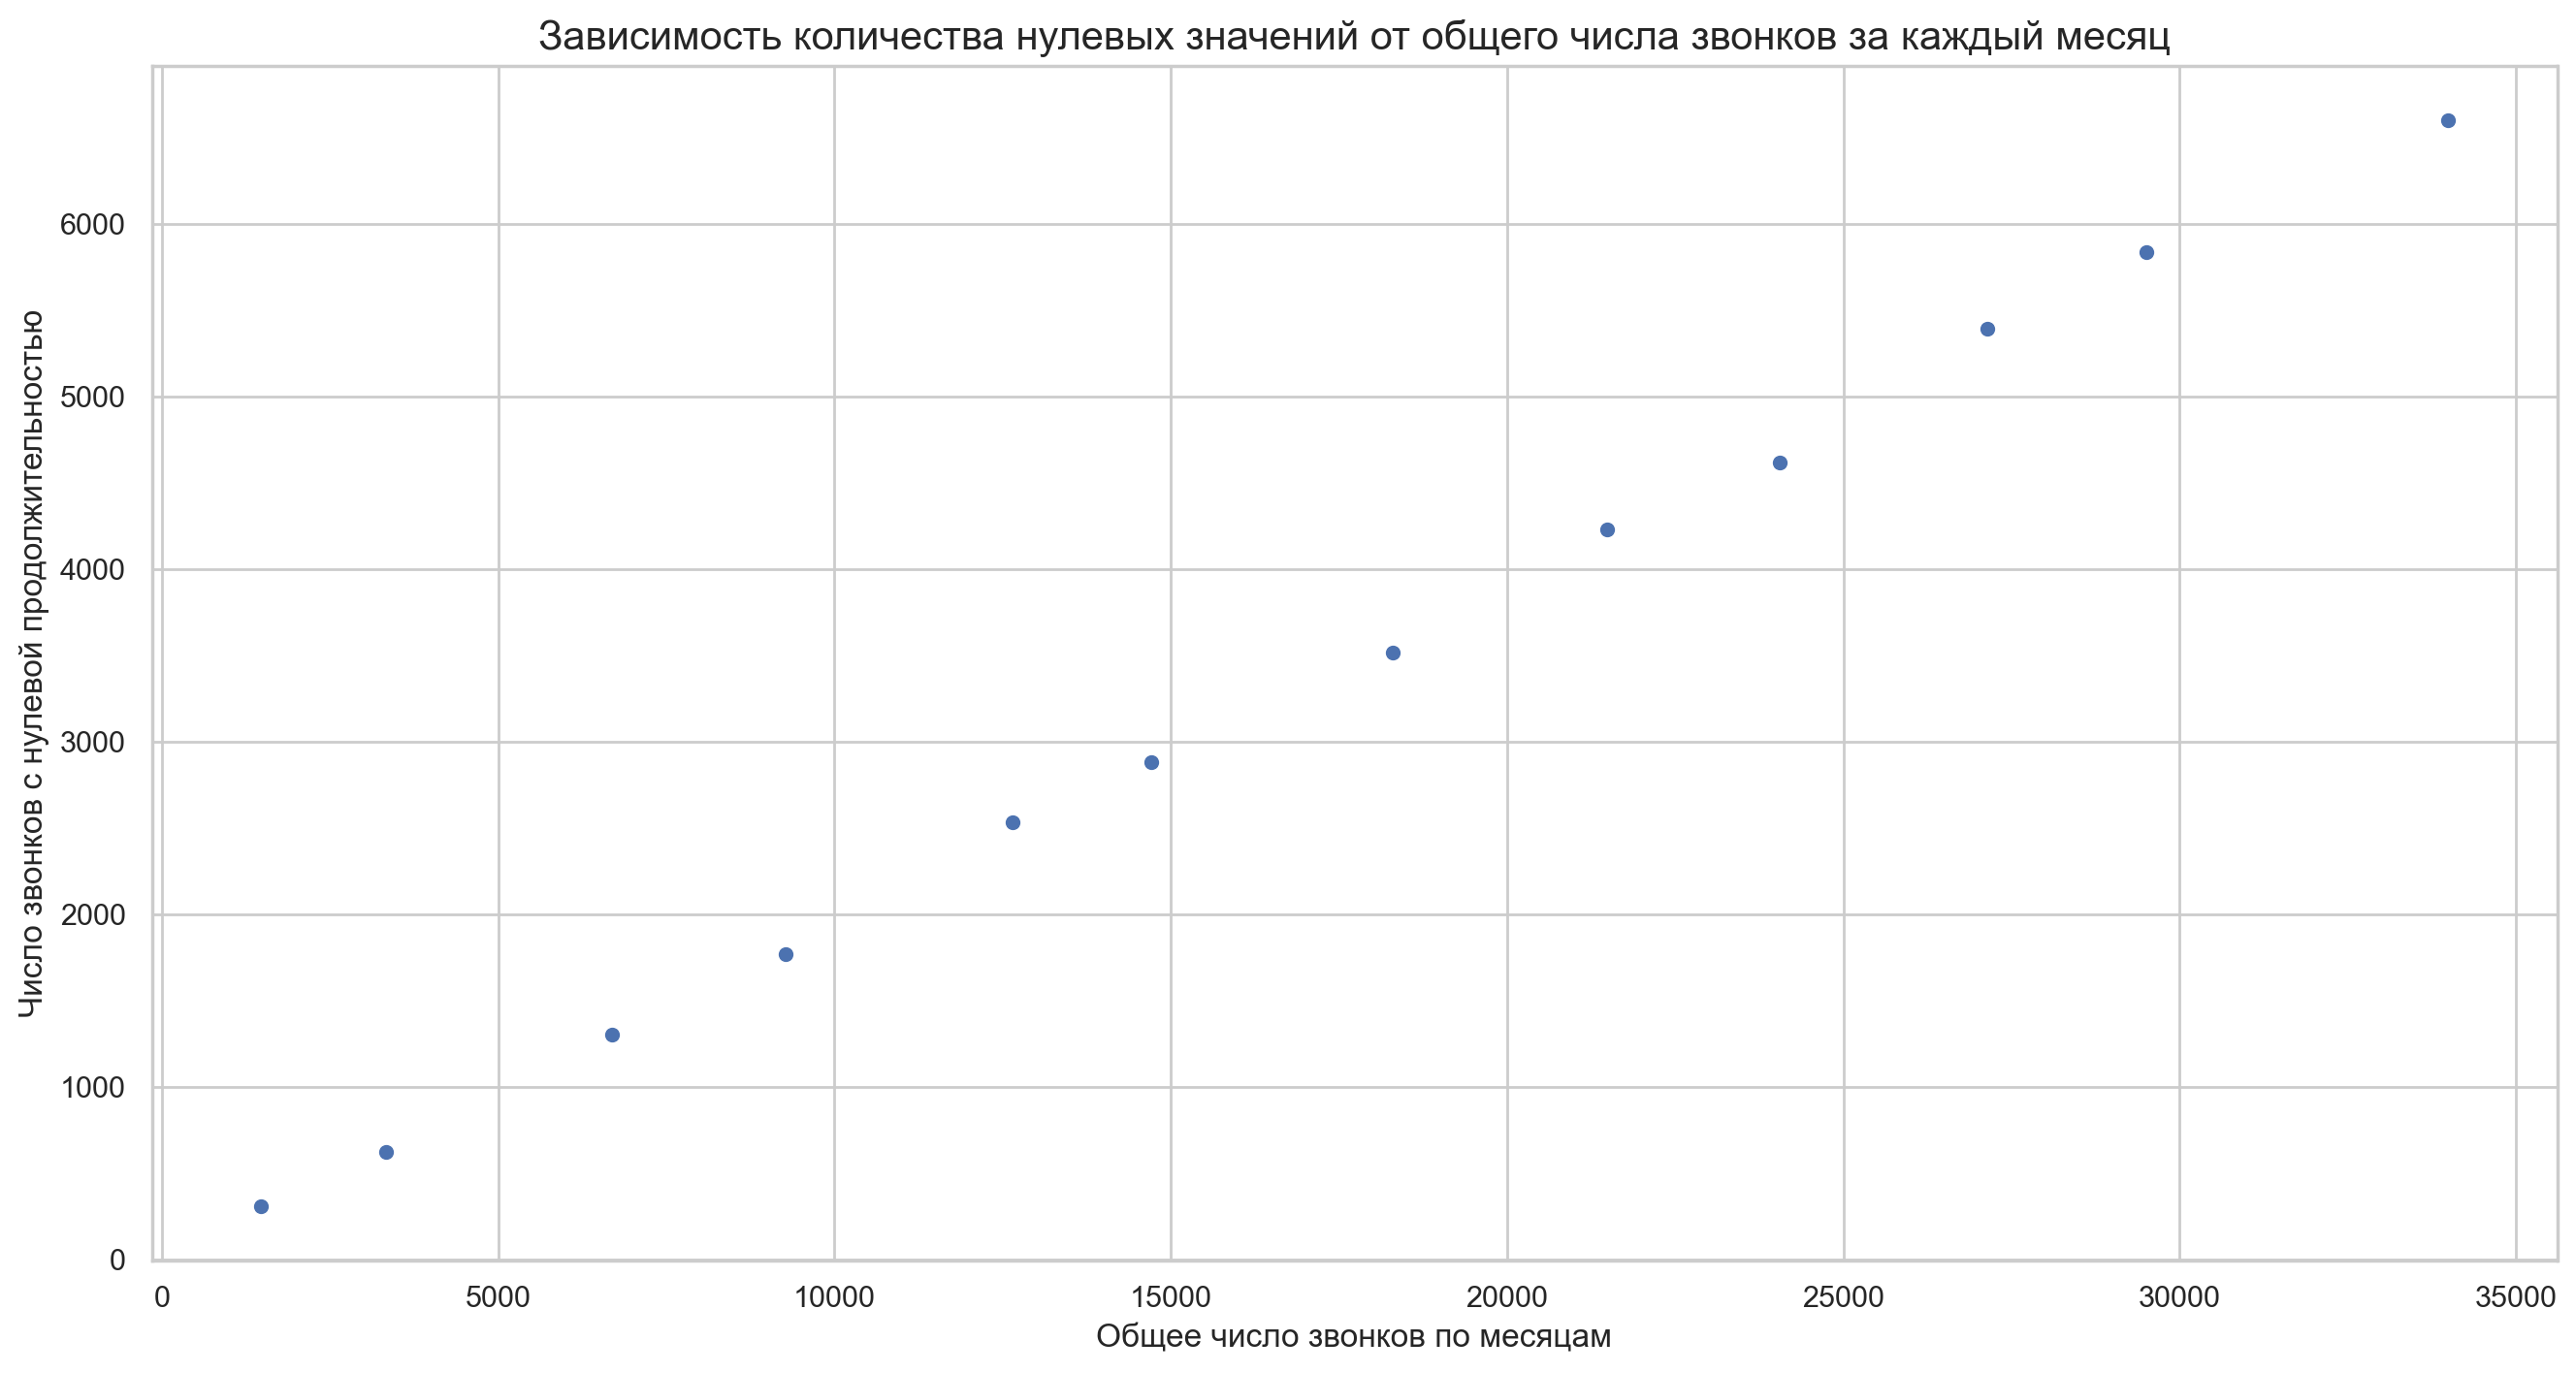

In [13]:
# добавим столбец со значением месяца
calls['month'] = calls['call_date'].dt.month

# построим график зависимости количества нулевых значений от общего числа звонков за каждый месяц
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls['null_ratio'] = round(null_calls['nulls_count'] / null_calls['id'], 3)

plt.figure(figsize=(16, 8))
sns.scatterplot(x='id', y='nulls_count', data=null_calls)
plt.xlabel('Общее число звонков по месяцам', fontsize=12)
plt.ylabel('Число звонков с нулевой продолжительностью', fontsize=12)
plt.title('Зависимость количества нулевых значений от общего числа звонков за каждый месяц', fontsize=15)
plt.show()

Таким образом, доля звонков с нулевой продолжительностью стационарна, и их появление систематично. Округлим все значения в большую сторону (т.к. тариф считается по минутам), а нулевые значения заменим на 1.

In [14]:
# округлим все значения в большую сторону, а нулевые значения заменим на 1
calls['duration'] = calls['duration'].apply(np.ceil)
calls.loc[calls['duration'] == 0, 'duration'] = 1

**2. Интернет-сессии**

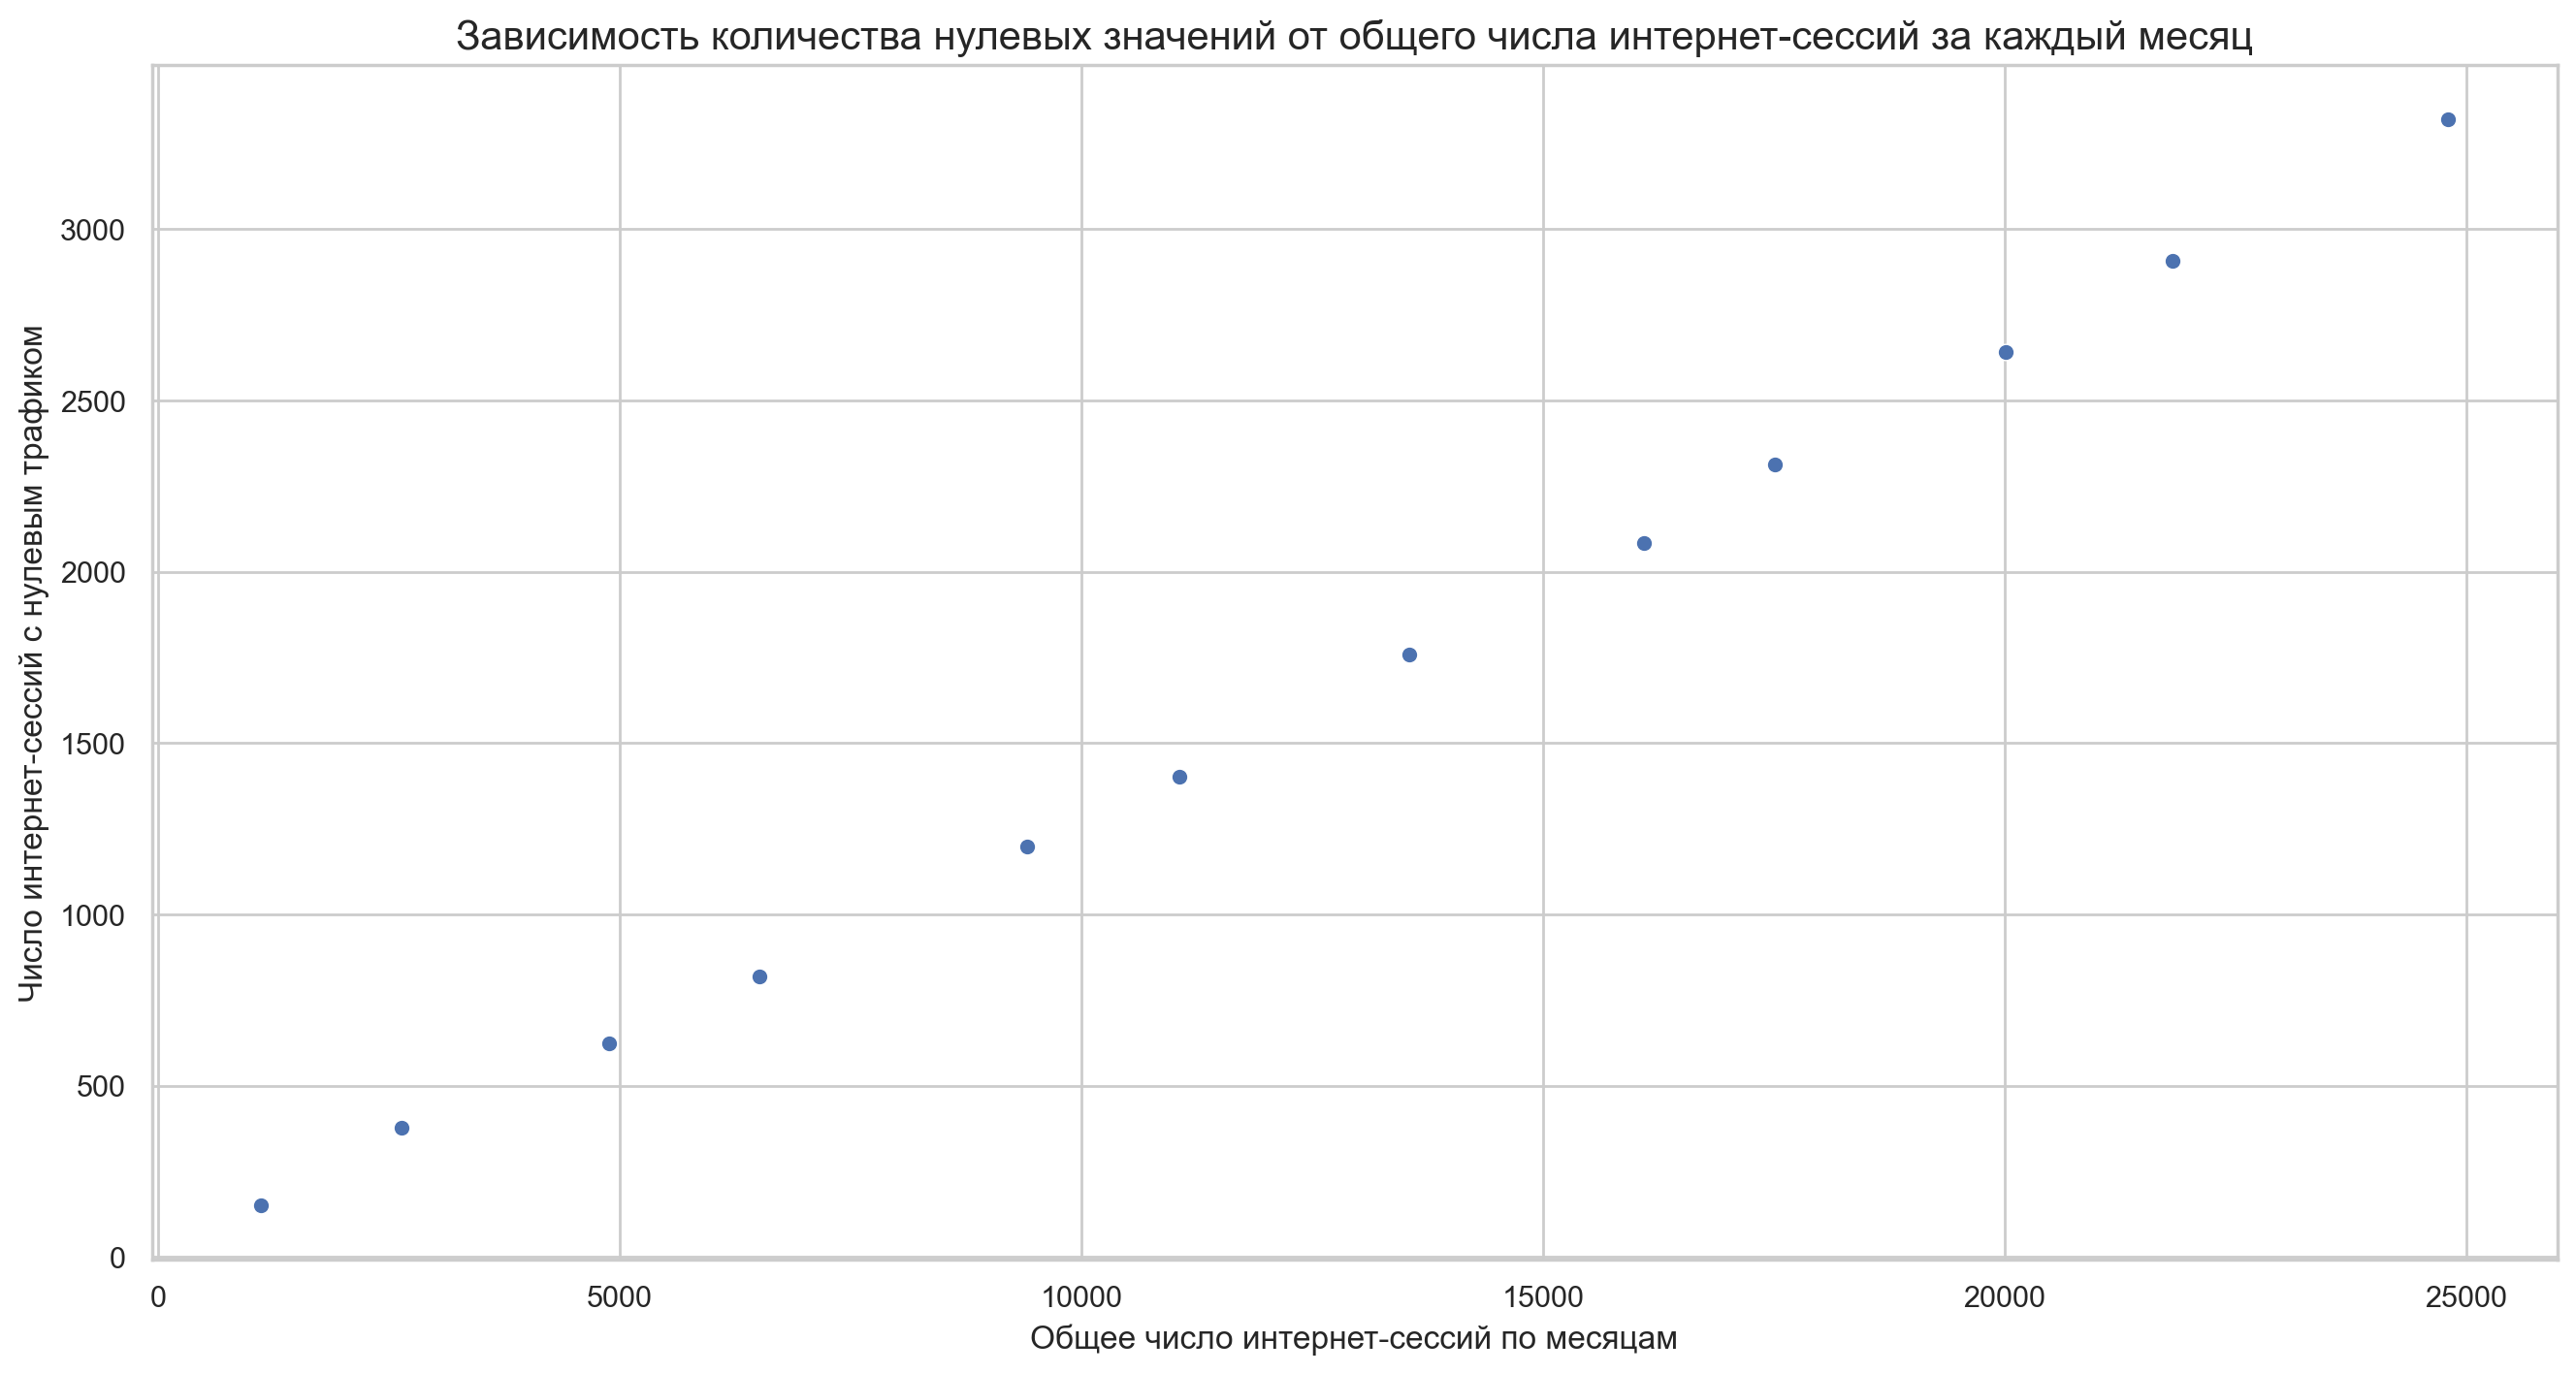

In [15]:
# добавим столбец со значением месяца
internet['month'] = internet['session_date'].dt.month

# построим график зависимости количества нулевых значений от общего числа Интернет-сессий за каждый месяц
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'], 3)

plt.figure(figsize=(16, 8))
sns.scatterplot(x='id', y='nulls_count', data=null_mb)
plt.xlabel('Общее число интернет-сессий по месяцам', fontsize=12)
plt.ylabel('Число интернет-сессий с нулевым трафиком', fontsize=12)
plt.title('Зависимость количества нулевых значений от общего числа интернет-сессий за каждый месяц', fontsize=15)
plt.show()

Вывод по нулевым значениям интернет-сесссий аналогичен. Округлим все значения в большую сторону (т.к. тариф считается по мегабайтам), а нулевые значения заменим на 1.

In [16]:
# округлим все значения в большую сторону, а нулевые значения заменим на 1
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

**Вывод:**

- Звонки. Округлили все значения в большую сторону (т.к. тариф считается по минутам), а нулевые значения заменили на 1.
- Интернет-сессии. Округлили все значения в большую сторону (т.к. тариф считается по мегабайтам), а нулевые значения заменили на 1.

### Сбор сводной информации для каждого пользователя

Найдем для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

In [18]:
# для подсчета при создании сводной таблицы сгенерируем уникальный код из имени и населенного пункта
users['unique_name'] = users['city'] + users['first_name'] + users['last_name']

# сводная таблица по звонкам
calls_temp = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

# сводная таблица по сообщениям
messages['month'] = messages['message_date'].dt.month
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']

# сводная таблица по интернет-трафику
internet['month'] = internet['session_date'].dt.month
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']

# объединяем все три сводные таблицы в одну
dfs = [calls_grouped, messages_grouped, internet_grouped]
grouped_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dfs)
grouped_data.head(10)

duration  calls  messages   mb_used
user_id month                                     
1000    5        164.00  22.00     22.00  2,257.00
        6        187.00  43.00     60.00 23,262.00
        7        346.00  47.00     75.00 14,017.00
        8        418.00  52.00     81.00 14,072.00
        9        478.00  58.00     57.00 14,583.00
        10       363.00  57.00     73.00 14,717.00
        11       344.00  43.00     58.00 14,769.00
        12       341.00  46.00     70.00  9,829.00
1001    11       444.00  59.00       NaN 18,460.00
        12       430.00  63.00       NaN 14,059.00

Теперь для каждого пользователя посчитаем месячную выручку (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [19]:
# пропущенные значения заменяем на нули
grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0

# добавим наименование используемого тарифа для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

grouped_data.head()

duration  calls  messages   mb_used tariff
user_id month                                            
1000    5        164.00  22.00     22.00  2,257.00  ultra
        6        187.00  43.00     60.00 23,262.00  ultra
        7        346.00  47.00     75.00 14,017.00  ultra
        8        418.00  52.00     81.00 14,072.00  ultra
        9        478.00  58.00     57.00 14,583.00  ultra

In [20]:
# функция подсчета выручки с каждого пользователя в месяц
def det_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

grouped_data['revenue'] = grouped_data.apply(det_revenue, axis=1)
grouped_data.head(10)

duration  calls  messages   mb_used tariff  revenue
user_id month                                                     
1000    5        164.00  22.00     22.00  2,257.00  ultra 1,950.00
        6        187.00  43.00     60.00 23,262.00  ultra 1,950.00
        7        346.00  47.00     75.00 14,017.00  ultra 1,950.00
        8        418.00  52.00     81.00 14,072.00  ultra 1,950.00
        9        478.00  58.00     57.00 14,583.00  ultra 1,950.00
        10       363.00  57.00     73.00 14,717.00  ultra 1,950.00
        11       344.00  43.00     58.00 14,769.00  ultra 1,950.00
        12       341.00  46.00     70.00  9,829.00  ultra 1,950.00
1001    11       444.00  59.00      0.00 18,460.00  smart 1,155.47
        12       430.00  63.00      0.00 14,059.00  smart   550.00

**Вывод:**

Для каждого пользователя были найдены:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

Для каждого пользователя была посчитана месячная выручка.

### Вывод по шагу "Предобработка данных"

1. Все даты были заменены со строчного формата на временной.


2. Так как тариф считается по минутам и мегабайтам, все значения звонков и интернет-сессий были округлены в большую сторону, а нулевые значения заменены на 1.


3. Для каждого пользователя были определены количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам и объем израсходованного интернет-трафика по месяцам. Для каждого пользователя была посчитана месячная выручка.

## Анализ данных

Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц.

In [21]:
# создадим сводную таблицу с группировкой по пользователю
medians = grouped_data.pivot_table(
    index='user_id', 
    values=['duration', 'messages', 'mb_used', 'revenue'], 
    aggfunc='median')

for user_id in users['user_id']:
    medians.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
    
medians.head()

,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,345.00,"14,327.50",65.00,"1,950.00",ultra
1001,437.00,"16,259.50",0.00,852.73,smart
1002,221.00,"17,615.00",11.00,990.43,smart
1003,844.00,"11,369.00",83.00,"1,950.00",ultra
1004,136.50,"17,831.00",154.50,"1,950.00",ultra


Найдем медиану, дисперсию и стандартное отклонение.

In [22]:
# описательная статистика
medians.dropna(subset=['duration'], inplace=True)
desc_stat = medians.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
desc_stat

duration                    mb_used                        messages  \
         median    std       var    median      std           var   median   
tariff                                                                       
smart    453.00 164.61 27,097.88 16,955.00 4,181.50 17,484,927.93    28.50   
ultra    550.50 311.49 97,026.95 19,751.75 8,901.98 79,245,171.84    47.50   

                       
         std      var  
tariff                 
smart  28.01   784.60  
ultra  49.24 2,424.26

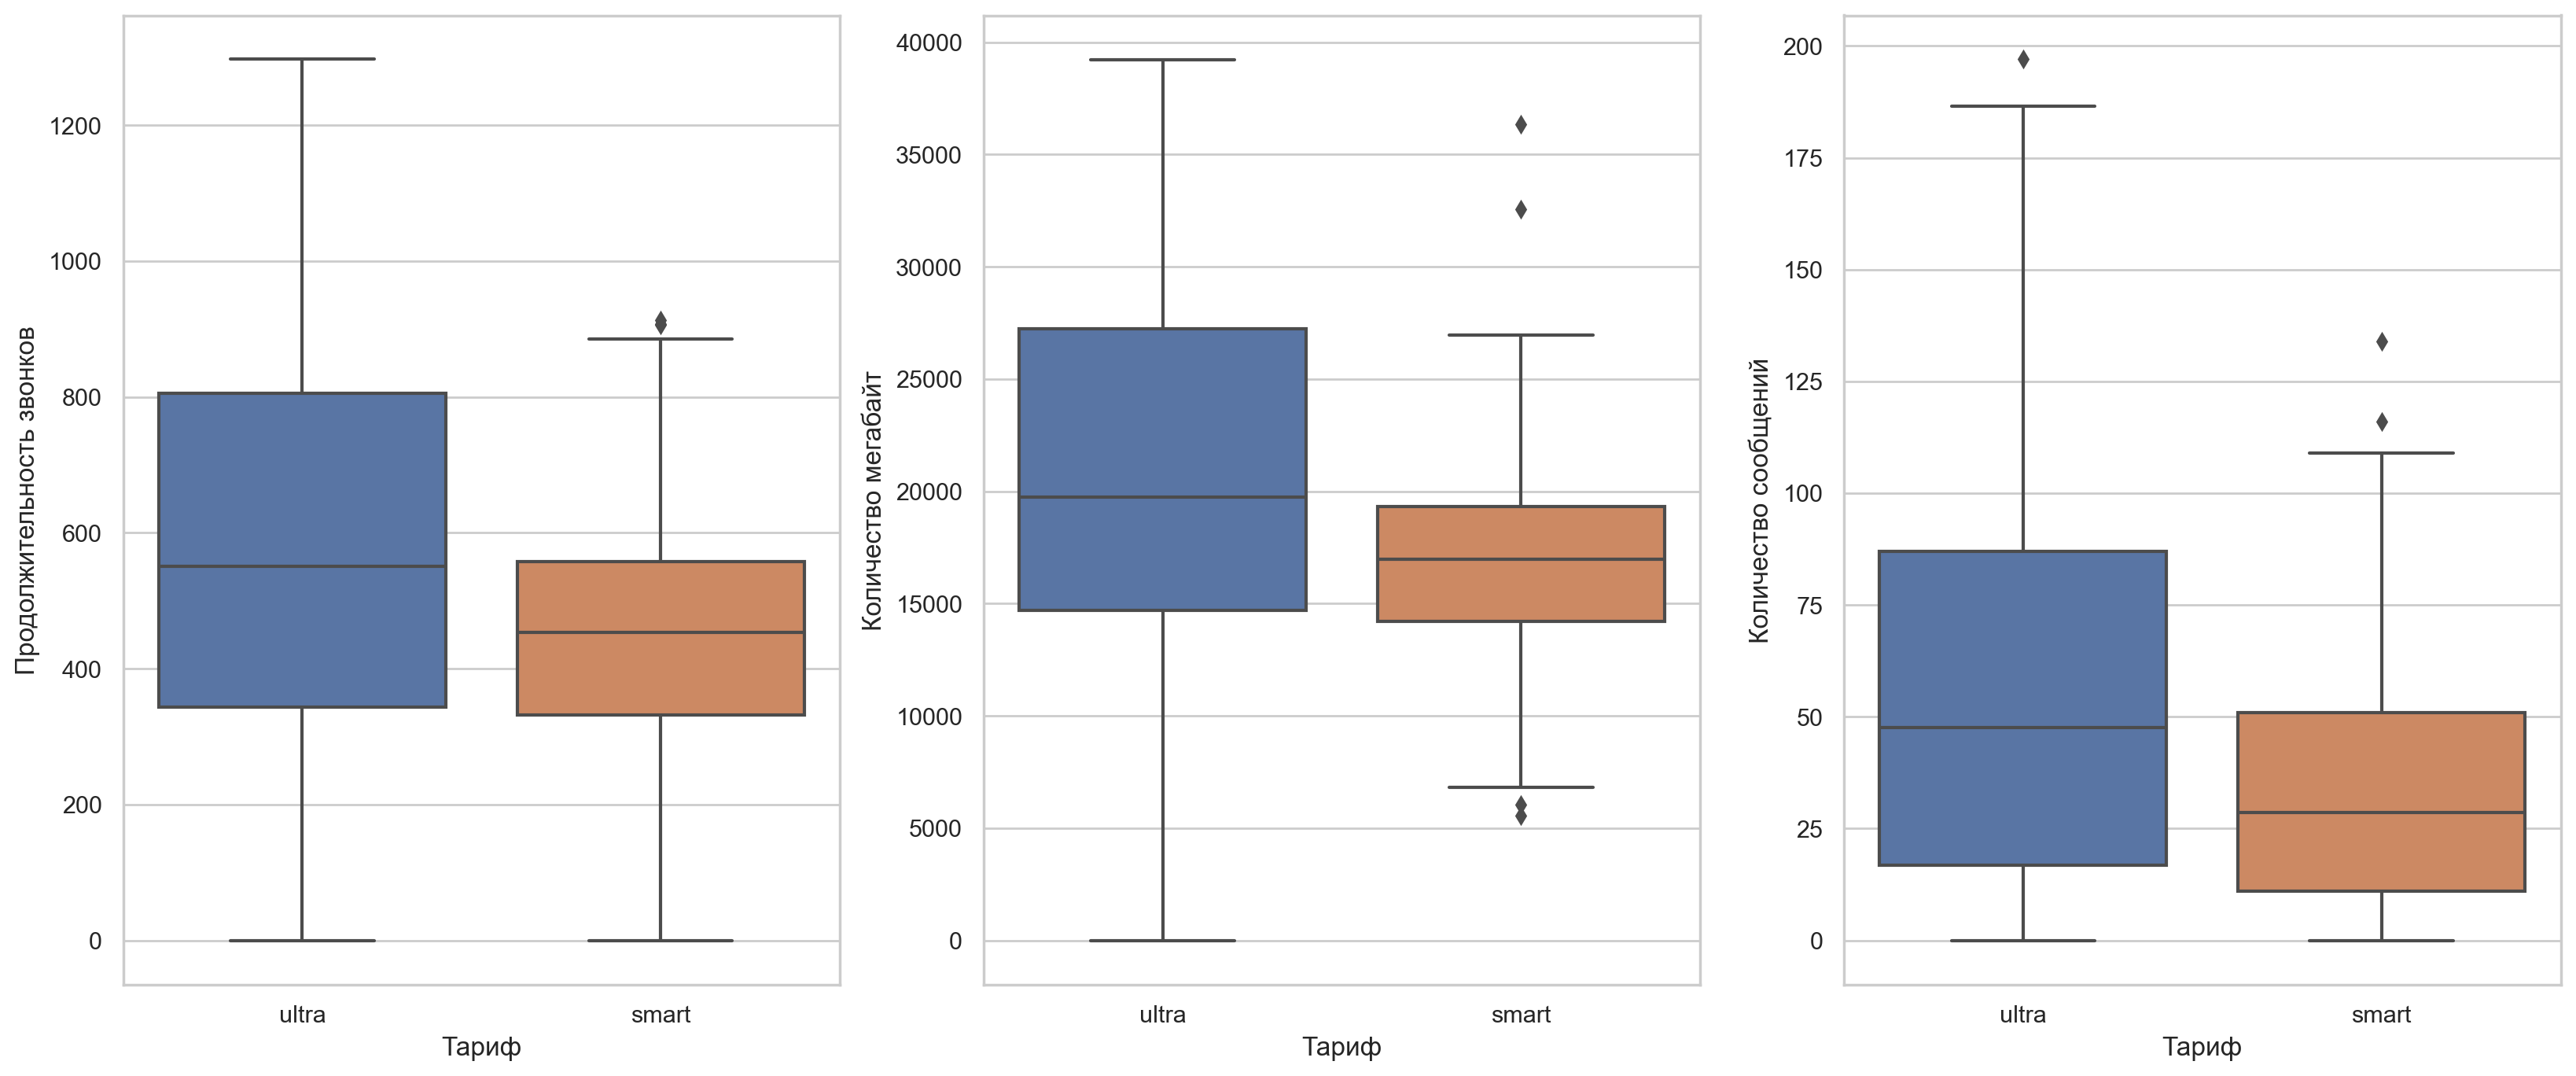

In [23]:
# построим боксплоты
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# звонки
sns.boxplot(ax=axes[0], x="tariff", y='duration', data=medians)
axes[0].set(xlabel='Тариф', ylabel='Продолжительность звонков')

# мегабайты
sns.boxplot(ax=axes[1], x="tariff", y='mb_used', data=medians)
axes[1].set(xlabel='Тариф', ylabel='Количество мегабайт')

# сообщения
sns.boxplot(ax=axes[2], x="tariff", y='messages', data=medians)
axes[2].set(xlabel='Тариф', ylabel='Количество сообщений')

plt.show()

Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

In [24]:
# сохраним статистические метрики для каждой пары месяц-тариф
# в одной таблице stats_df (среднее значение, стандартное отклонение, медиана)

stats_df = grouped_data.pivot_table(
            index=['month', 'tariff'],\
            values=['calls', 'duration', 'messages', 'mb_used'],\
            aggfunc=['mean', 'std', 'median']\
).round(2).reset_index()

stats_df.columns=['month', 'tariff', 'calls_mean', 'sessions_mean', 'messages_mean', 'minutes_mean',
                                     'calls_std',  'sessions_std', 'messages_std', 'minutes_std', 
                                     'calls_median', 'sessions_median', 'messages_median',  'minutes_median']

stats_df.head(10)

,month,tariff,calls_mean,sessions_mean,messages_mean,minutes_mean,calls_std,sessions_std,messages_std,minutes_std,calls_median,sessions_median,messages_median,minutes_median
0,1,smart,27.68,209.65,"8,528.59",18.24,20.81,158.87,"6,454.53",16.20,20.50,166.50,"7,112.50",15.00
1,1,ultra,59.44,440.89,"13,154.67",33.78,41.64,279.97,"6,871.91",30.67,51.00,399.00,"14,810.00",32.00
2,2,smart,40.19,306.31,"11,617.34",24.09,25.39,195.01,"6,257.13",21.75,38.50,265.50,"12,577.50",20.00
3,2,ultra,41.54,304.67,"11,788.33",21.96,40.97,304.28,"10,655.24",26.77,25.00,174.00,"7,338.00",5.50
4,3,smart,54.32,400.53,"15,131.21",31.86,25.54,196.27,"5,837.19",26.80,59.00,420.00,"15,697.00",23.00
5,3,ultra,67.68,503.08,"17,553.51",32.30,44.84,342.20,"10,963.07",41.62,57.00,427.00,"17,515.00",20.00
6,4,smart,51.31,377.00,"13,486.08",30.74,25.70,191.10,"5,707.10",24.54,52.00,382.00,"14,111.50",28.00
7,4,ultra,66.51,470.07,"16,845.25",31.56,34.67,274.35,"9,728.33",37.51,63.00,468.00,"16,662.00",17.00
8,5,smart,55.24,398.40,"15,832.75",33.77,25.38,190.68,"5,987.64",27.04,59.00,443.00,"16,356.00",30.00
9,5,ultra,75.91,524.87,"19,383.19",37.85,38.81,297.40,"10,056.52",40.31,76.50,530.00,"18,718.00",25.00


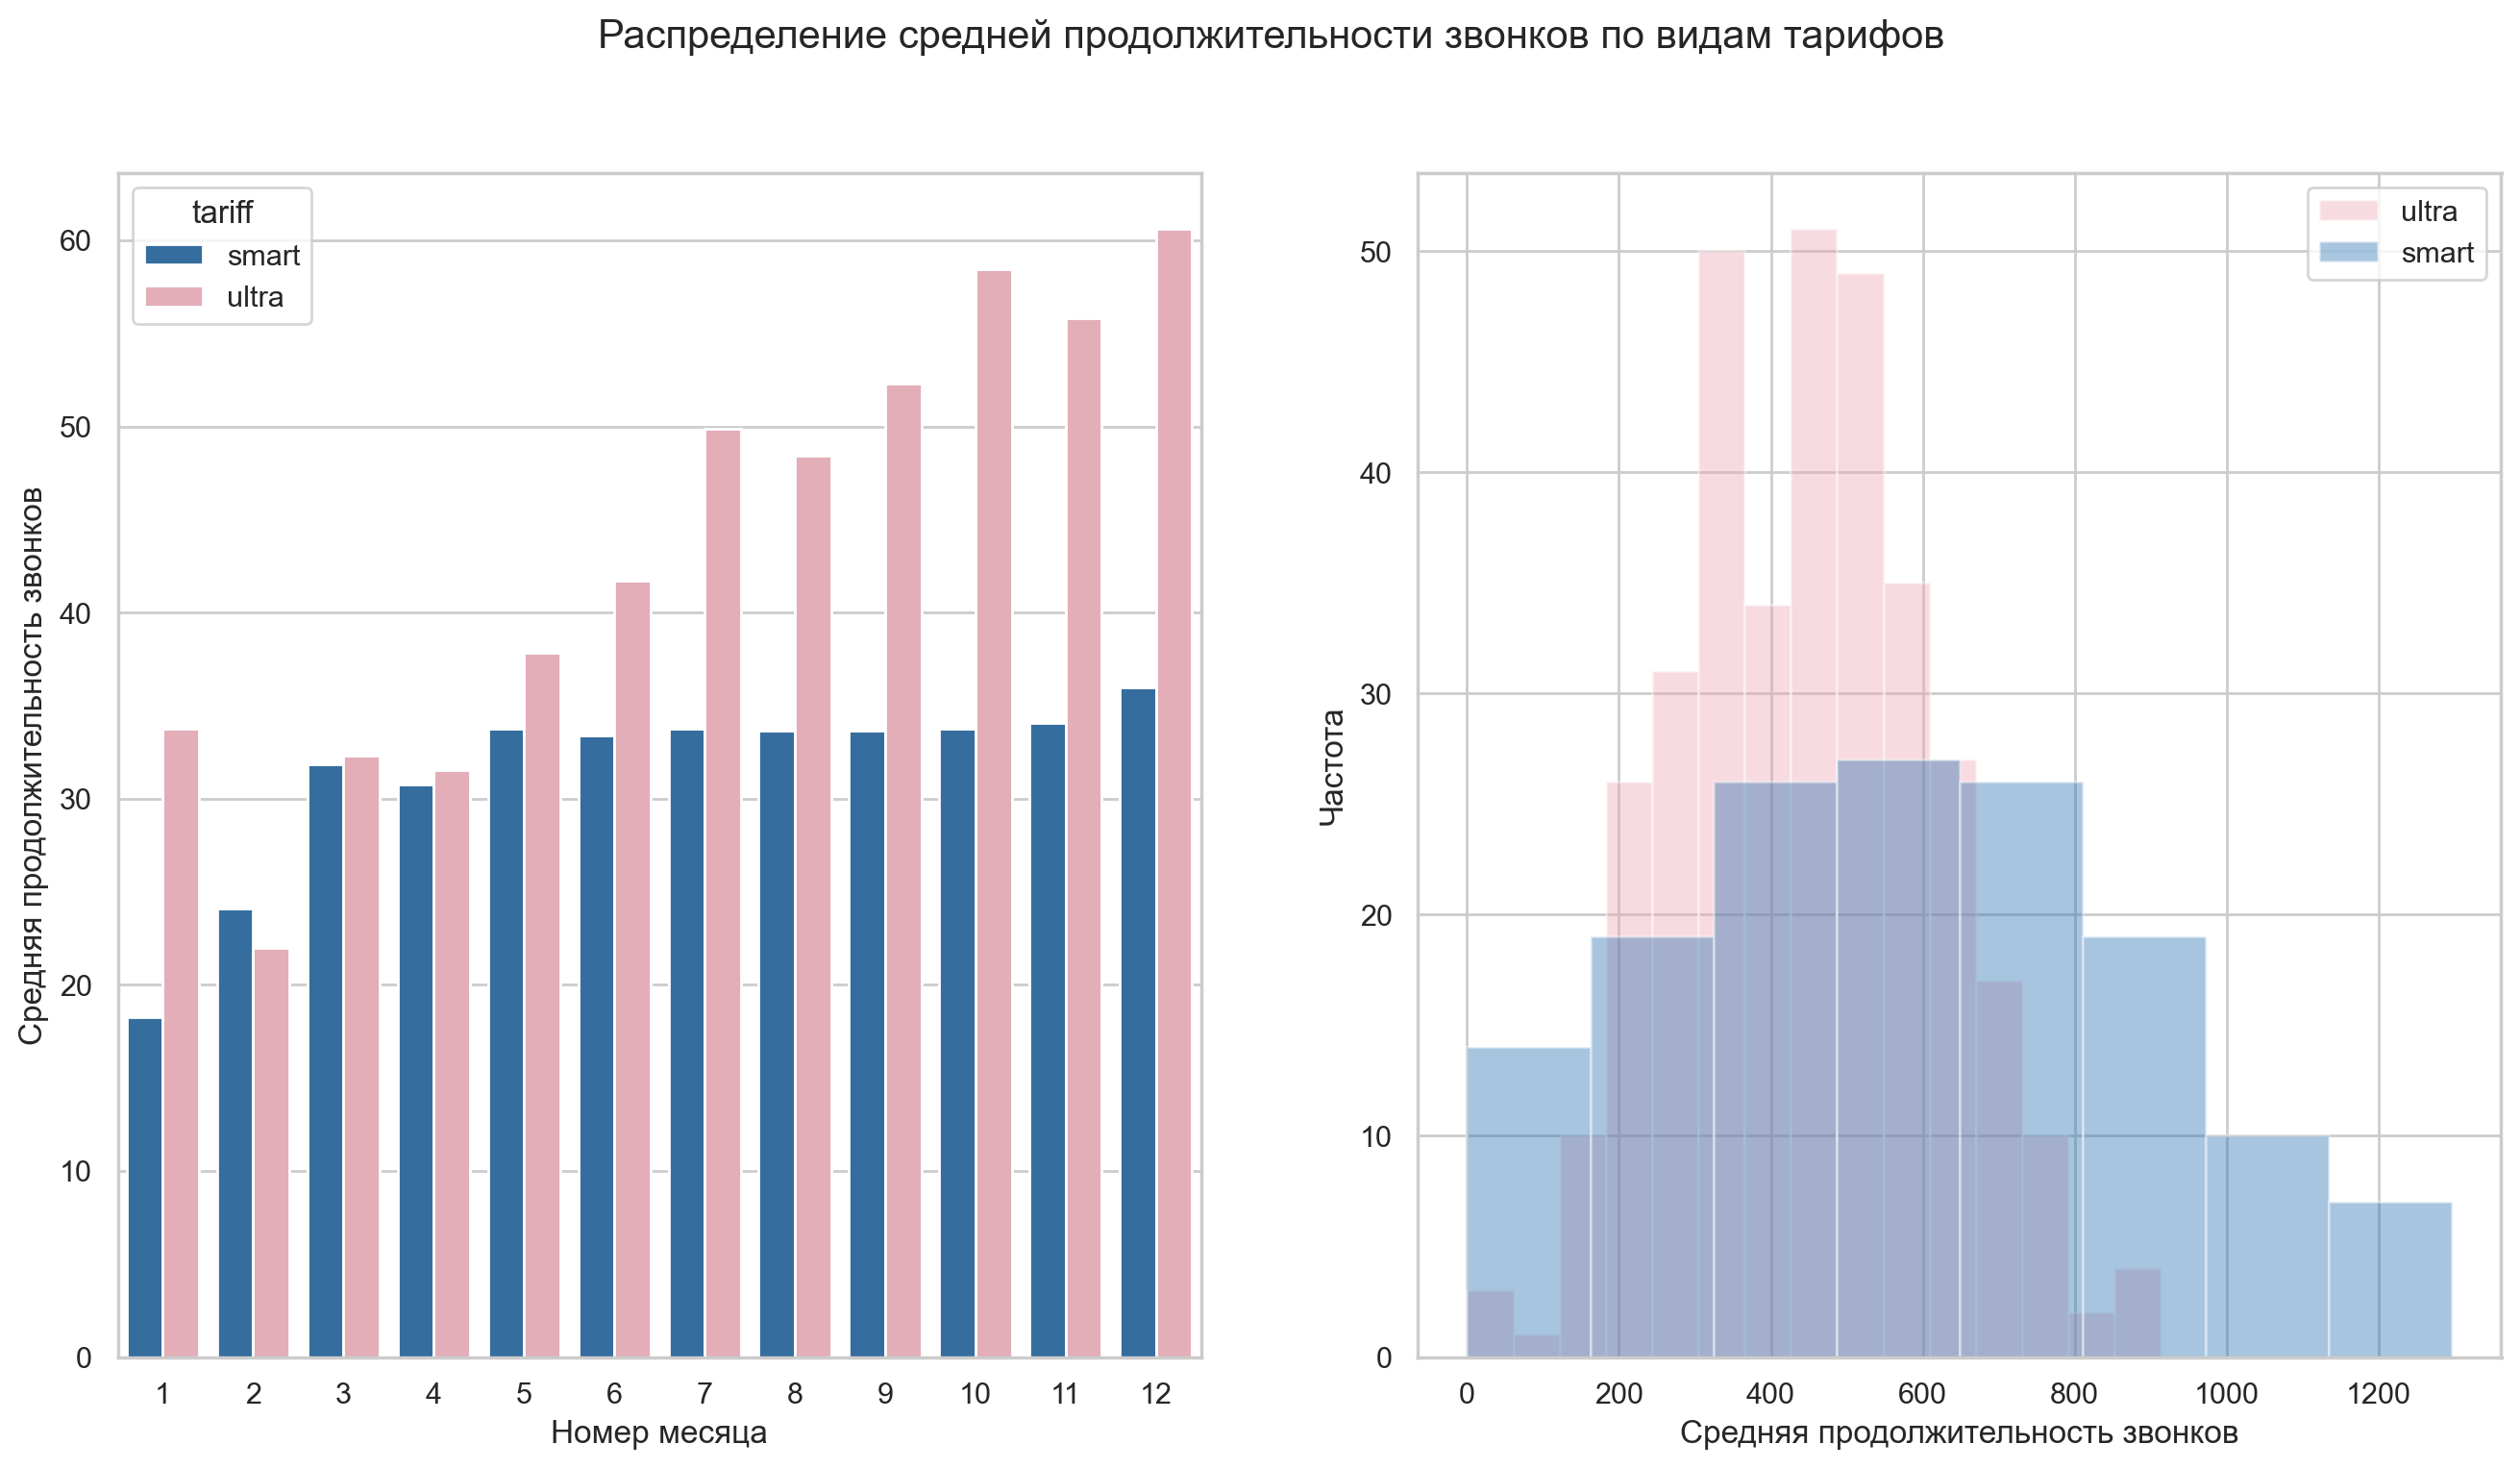

In [25]:
# построим распрделение средней продолжительности звонков по видам тарифов и месяцам
plt.figure(figsize=(16, 8))
plt.suptitle('Распределение средней продолжительности звонков по видам тарифов',  fontsize=15)

plt.subplot(1, 2, 1)
sns.barplot(x='month',
            y='minutes_mean',
            hue="tariff",
            data=stats_df,
            palette=['#256EB0', '#ECA5B3'])
plt.xlabel('Номер месяца', fontsize=12)
plt.ylabel('Средняя продолжительность звонков', fontsize=12)

plt.subplot(1, 2, 2)
sns.distplot(medians.query('tariff == "smart"')['duration'], kde=False, label='tariff', color='#ECA5B3')
sns.distplot(medians.query('tariff == "ultra"')['duration'], kde=False, label='tariff', color='#256EB0')
_ = plt.legend(['ultra', 'smart'])
plt.xlabel('Средняя продолжительность звонков', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.show()

Средняя длительность разговоров у абонентов тарифа Ultra больше, чем у абонентов тарифа Smart. В течение года пользователи обоих тарифов увеличивают среднюю продолжительность своих разговоров. Рост средней длительности разговоров у абонентов тарифа Smart равномерный в течение года. Пользователи тарифа Ultra не проявляют подобной линейной стабильности. Стоит отметить, что феврале у абонентов обоих тарифных планов наблюдались самые низкие показатели.

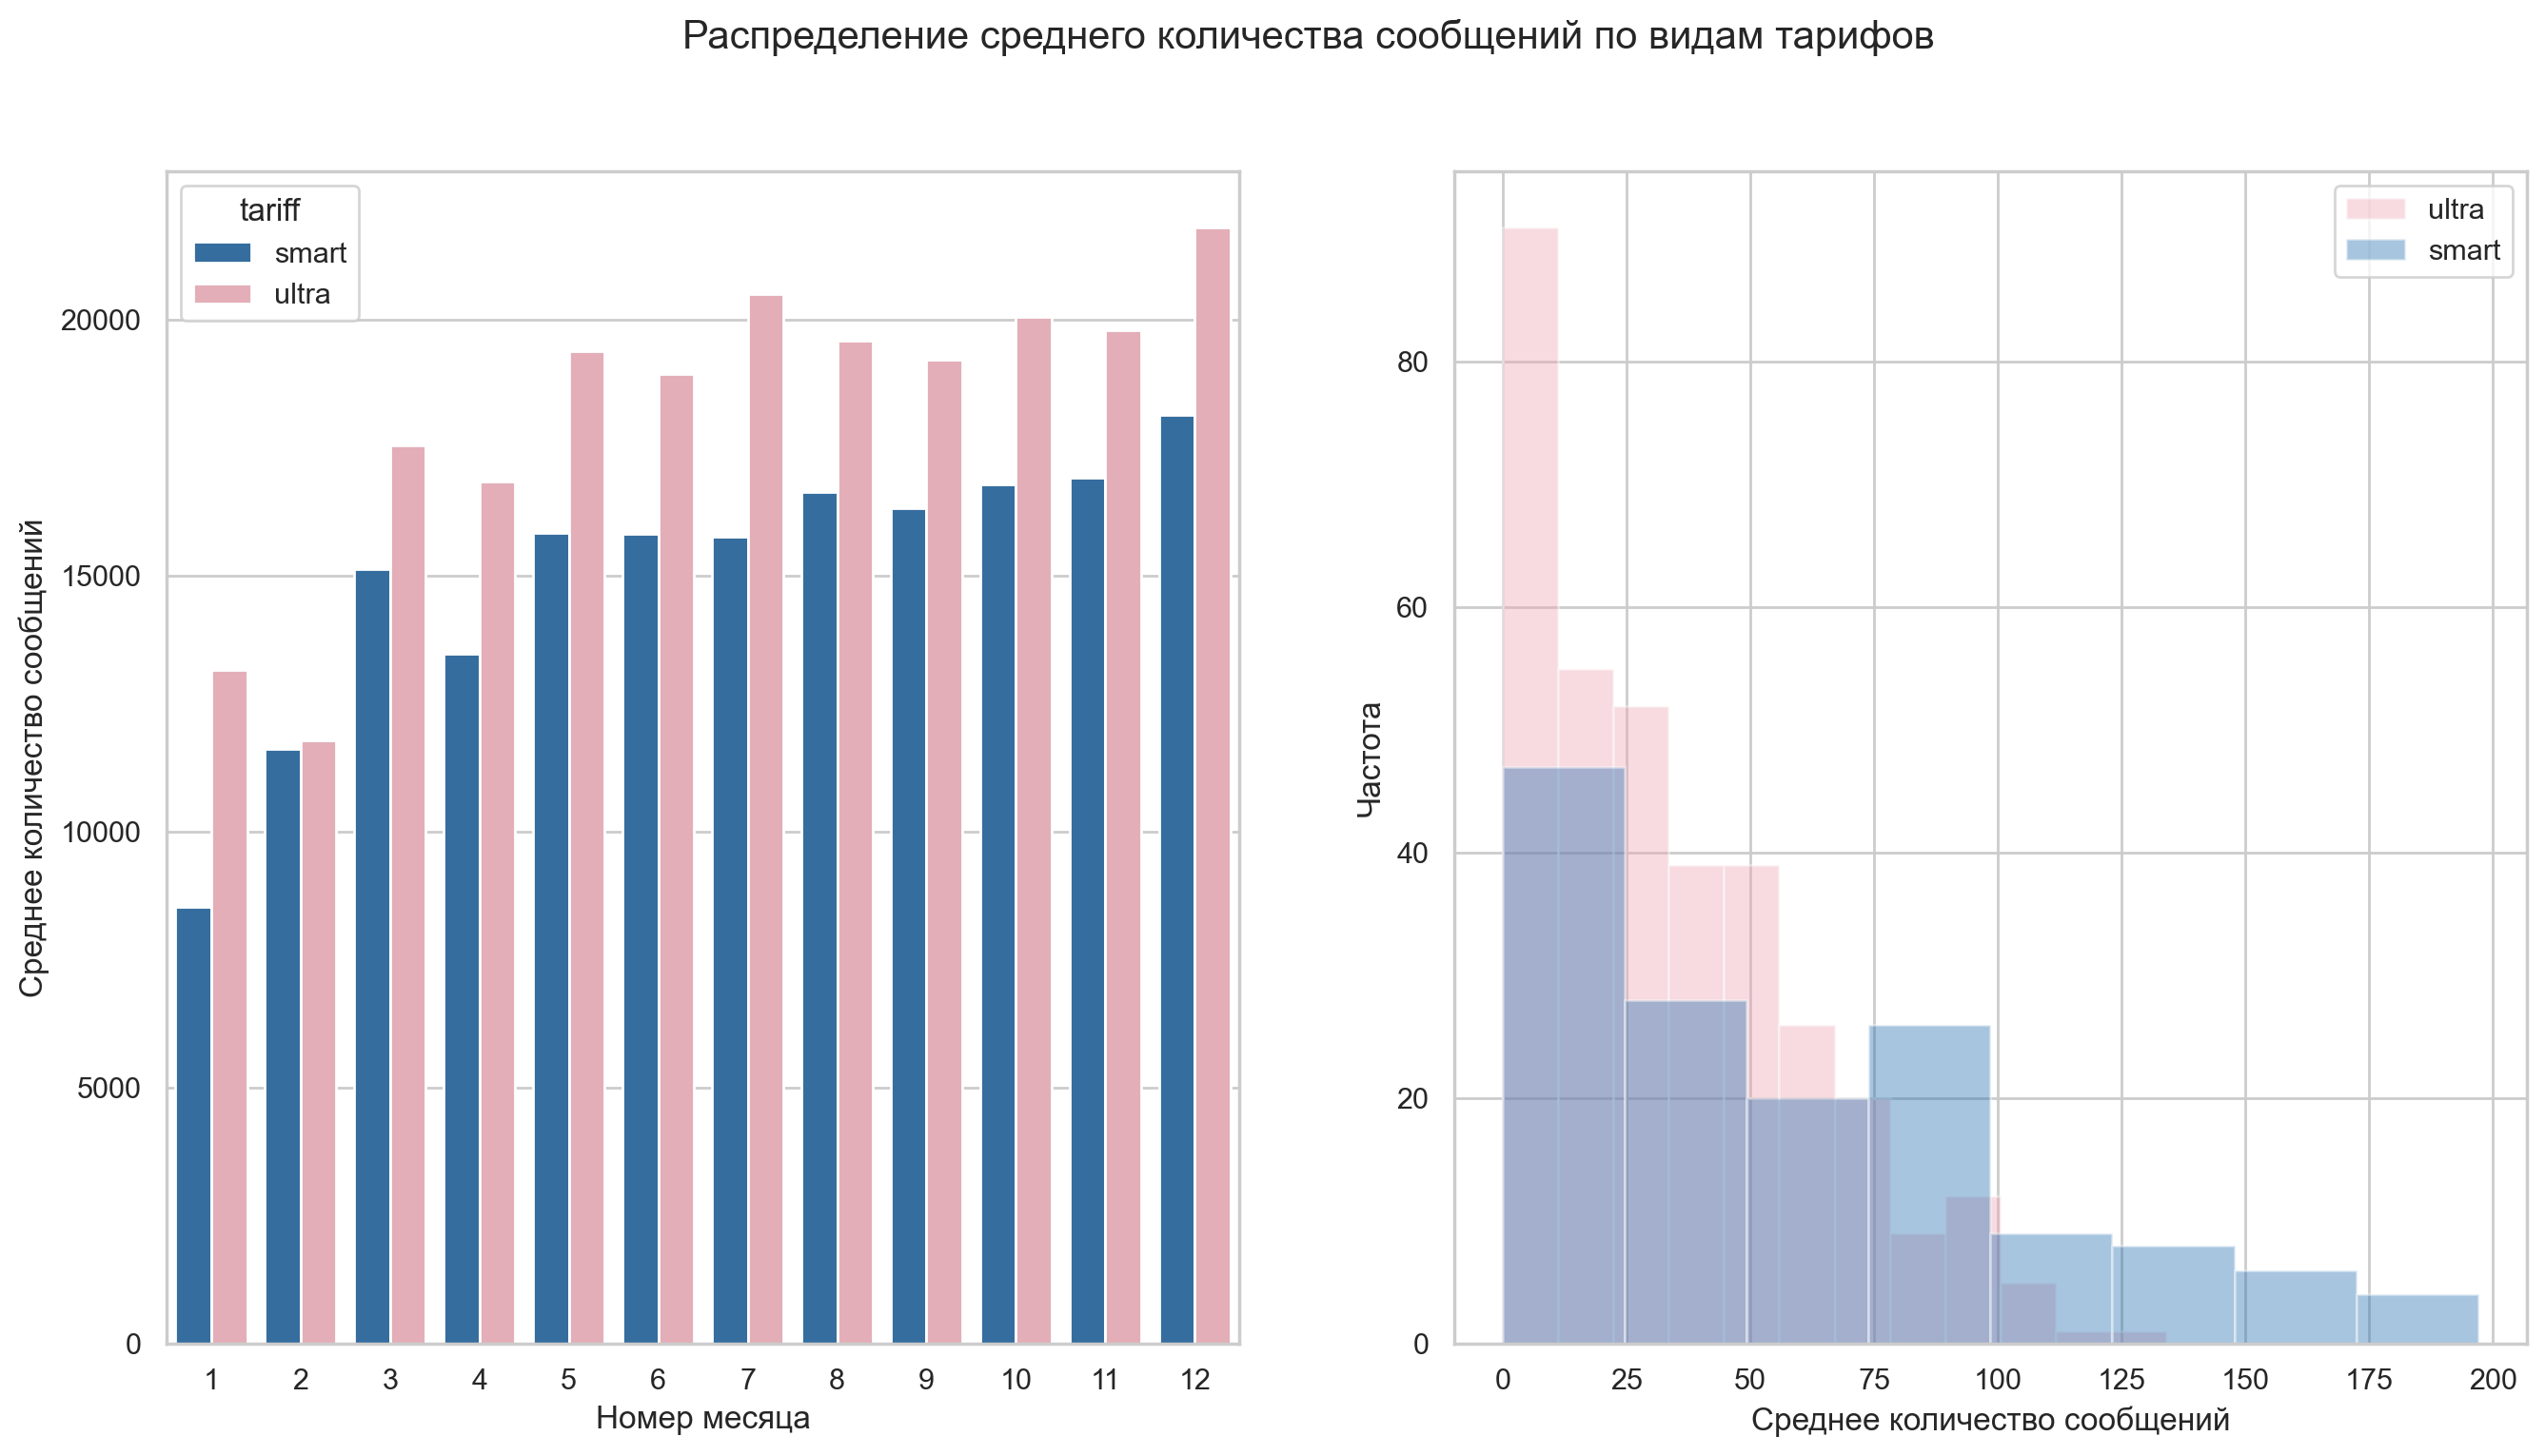

In [26]:
# построим распрделение среднего количества сообщений по видам тарифов и месяцам
plt.figure(figsize=(16, 8))
plt.suptitle('Распределение среднего количества сообщений по видам тарифов',  fontsize=15)

plt.subplot(1, 2, 1)
sns.barplot(x='month',
            y='messages_mean',
            hue="tariff",
            data=stats_df,
            palette=['#256EB0', '#ECA5B3'])
plt.xlabel('Номер месяца', fontsize=12)
plt.ylabel('Среднее количество сообщений', fontsize=12)

plt.subplot(1, 2, 2)
sns.distplot(medians.query('tariff == "smart"')['messages'], kde=False, label='tariff', color='#ECA5B3')
sns.distplot(medians.query('tariff == "ultra"')['messages'], kde=False, label='tariff', color='#256EB0')
_ = plt.legend(['ultra', 'smart'])
plt.xlabel('Среднее количество сообщений', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.show()

В среднем количество сообщений пользователи тарифа Ultra отправляют больше - почти на 20 сообщений больше, чем пользователи тарифа Smart. Количество сообщений в течение года на обоих тарифак растет. Динамика по отправке сообщений схожа с тенденциями по длительности разговоров: в феврале отмечено наименьшее количество сообщений за год и пользователи тарифа Ultra также проявляют нелинейную положительную динамику.

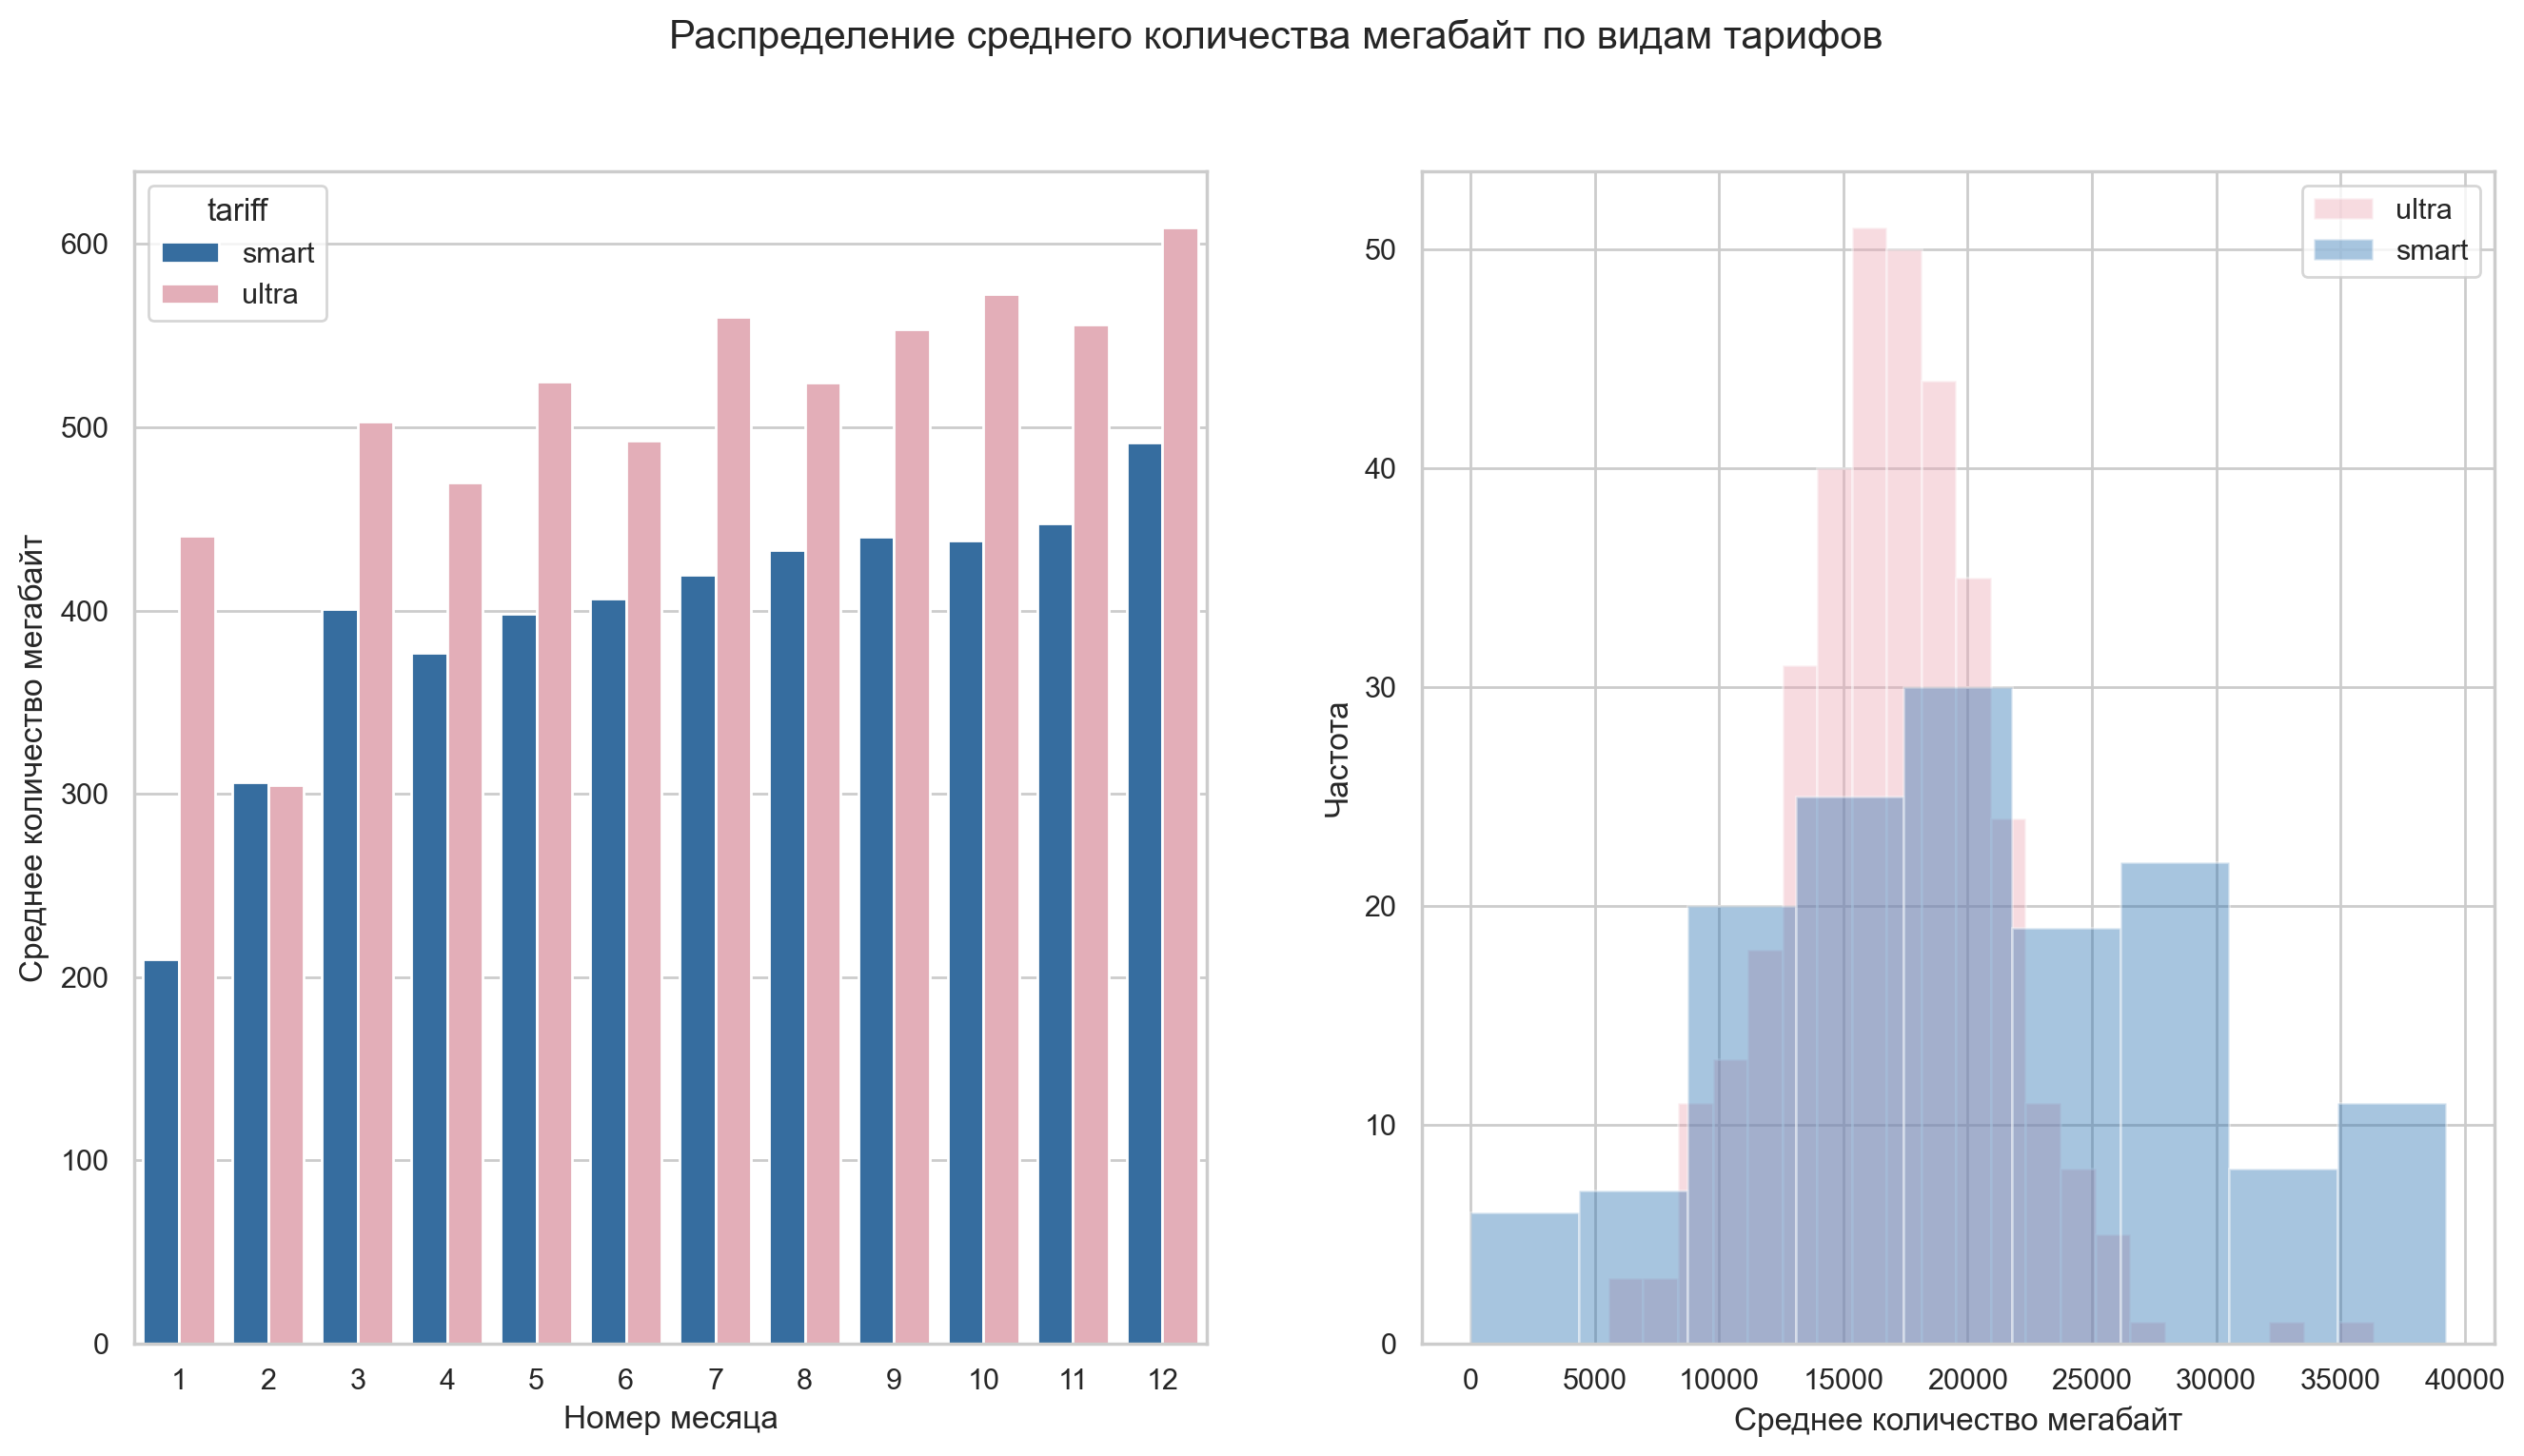

In [27]:
# построим распрделение среднего количества мегабайт по видам тарифов и месяцам
plt.figure(figsize=(16, 8))
plt.suptitle('Распределение среднего количества мегабайт по видам тарифов',  fontsize=15)

plt.subplot(1, 2, 1)
sns.barplot(x='month',
            y='sessions_mean',
            hue="tariff",
            data=stats_df,
            palette=['#256EB0', '#ECA5B3'])
plt.xlabel('Номер месяца', fontsize=12)
plt.ylabel('Среднее количество мегабайт', fontsize=12)

plt.subplot(1, 2, 2)
sns.distplot(medians.query('tariff == "smart"')['mb_used'], kde=False, label='tariff', color='#ECA5B3')
sns.distplot(medians.query('tariff == "ultra"')['mb_used'], kde=False, label='tariff', color='#256EB0')
_ = plt.legend(['ultra', 'smart'])
plt.xlabel('Среднее количество мегабайт', fontsize=12)
plt.ylabel('Частота', fontsize=12)

plt.show()

Меньше всего пользователи использовали интернет в январе, феврале и апреле. Чаще всего абоненты тарифа Smart тратят 15-17 Гб, а абоненты тарифного плана Ultra - 19-21 ГБ.

### Вывод "Анализ данных"

1. По гистограммам видим, что дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. Также на гистограммах видно, что мода у "Смарта" явно выражена.


2. Можно утверждать, что поведение пользователей тарифа "Ультра" более разнообразное с точки зрения потребления телекоммуникационных услуг. Пользователи дорогого тарифа более свободны в выборе того, как именно использовать объемы тарифного пакета: возможно, использование дорогого тарифа помогает им не думать о том, что в какой-то момент у них отключится интернет или закончится пакет по минутам разговора.

## Проверка гипотез

На этом этапе проверим две гипотезы:

1. Средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается. 
2. Средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов.

### Гипотеза 1 - Средняя выручка с пользователей тарифов «Ультра» и «Смарт» различается

- H0 — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».
- H1 — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
- α = 1%

In [29]:
# чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, 
# применим метод scipy.stats.ttest_ind
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = .01

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.4535744400867116e-281
Отвергаем нулевую гипотезу


In [30]:
# посмотрим на значения выручки
grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,987.66
ultra,"1,950.00"


**Вывод:**

- Средние значения выручки по тарифам различаются почти в 2 раза. Если у пользователя подключен тариф "Смарт" с абонентской платой в 550 рублей, то он скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета.

- В заключение можно подтвердить с уверенностью 99%, что доходы "Мегалайна" с пользователя по тарифу "Ультра" действительно отличаются по сравнению с доходами от тарифа "Смарт".

### Средняя выручка с пользователей из Москвы отличается от выручки с пользователей других регионов

- H0 — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
- H1 — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.
- α = 1%

In [31]:
# добавим наименование населенного пункта для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5030013194608627
Не получилось отвергнуть нулевую гипотезу


In [32]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
grouped_data['region'] = grouped_data['city'].apply(det_region)
grouped_data.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,"1,545.90"
Москва,"1,733.59"


**Вывод:**

- Данный статистический тест не дал возможности отвергнуть нулевую гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. Действительно, доходы в Московском регионе практически не отличаются от других населенных пунктов.

- Если бы мы отклонили нулевую гипотезу и констатировали, что доходы "Мегалайна" с каждого пользователя в Москве отличаются от доходов в других регионах, мы бы с вероятностью 50,3% ошиблись.

### Вывод по шагу "Проверка гипотез"

1. С уверенностью 99% можно утверждать, что доходы "Мегалайна" с пользователя по тарифу "Ультра" действительно отличаются по сравнению с доходами от тарифа "Смарт".


2. В то время как, доходы в Московском регионе практически не отличаются от других населенных пунктов.

## Общий вывод

Цель настоящего исследования - **определить перспективный тариф для телеком компании**. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент федерального оператора сотовой связи хочет понять, какой тариф приносит больше денег. В нашем распоряжении были данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Требовалось проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


1. По результатам статистического анализа было выявлено, что доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 1950 рублей и 988 рублей соответственно  (p−значение=o,  α=1%).


2. Особенности использования тарифов заключаются в следующем:
    - Пользователям тарифа «Смарт» не хватает услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще 438 рублей ежемесячно (+79,6%).
    - Пользователи тарифа «Ультра», напротив, не используют тарифный пакет в полном объеме.
    - Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,503) и составляет 188 руб.: 1734 руб. в Москве против 1546 руб в других населенных пунктах.